Parte de los métodos mostrados aquí han sido tomados del siguiente documento y adaptados a otros usos de caso de:
*texto en cursiva*
*Skforecast: time series forecasting with Python, Machine Learning and Scikit-learn by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) at* https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

bajo la licencia:
https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en#ref-same-license
# Sección nueva


# 1. Base de datos

https://www.kaggle.com/datasets/yasserh/walmart-dataset

This is the historical data that covers sales from 2010-02-05 to 2012-11-01, in the file Walmart_Store_sales. Within this file you will find the following fields:

Store - the store number

Date - the week of sales

Weekly_Sales - sales for the given store

Holiday_Flag - whether the week is a special holiday

week 1 – Holiday week 0 – Non-holiday week

Temperature - Temperature on the day of sale

Fuel_Price - Cost of fuel in the region

CPI – Prevailing consumer price index

Unemployment - Prevailing unemployment rate

Holiday Events<br />

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13<br />
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13<br />
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13<br />
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

# Single series modeling




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
plt.style.use('ggplot')
pd.set_option("display.max_columns", None)


import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/walmart-dataset")

print("Path to dataset files:", path)
df = pd.read_csv(path+'/Walmart.csv')

Path to dataset files: /kaggle/input/walmart-dataset


In [ ]:
!pip install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.0/815.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster, load_forecaster
from skforecast.metrics import calculate_coverage
from skforecast.plot import plot_prediction_intervals
import shap

In [ ]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
df['date']=pd.to_datetime(df['Date'],format='%d-%m-%Y')
df.drop('Date',axis=1,inplace=True)


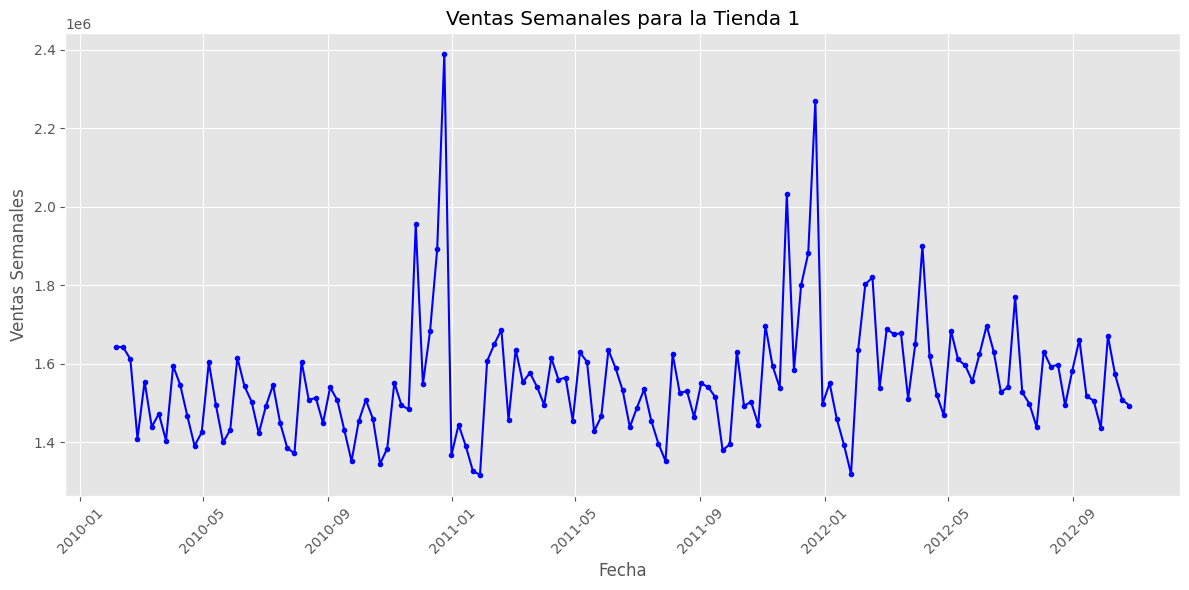

In [ ]:
store1_data = df[df['Store'] == 1]

# Crea el gráfico
plt.figure(figsize=(12, 6))
plt.plot(store1_data['date'], store1_data['Weekly_Sales'],".",ls="-",color='blue')
plt.xlabel('Fecha')
plt.ylabel('Ventas Semanales')
plt.title('Ventas Semanales para la Tienda 1')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df.set_index('date',inplace=True)
df.head()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
store1_data = df[df['Store'] == 1]


In [ ]:
store1_data = store1_data.asfreq('W-Fri',fill_value=np.nan)
store1_data.head()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
start_date = store1_data.index.min()
end_date = store1_data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=store1_data.index.freq)
is_index_complete = (store1_data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")


Index complete: True


Train dates : 2010-02-05 00:00:00 --- 2012-02-24 00:00:00  (n=108)
Test dates  : 2012-03-02 00:00:00 --- 2012-10-26 00:00:00  (n=35)


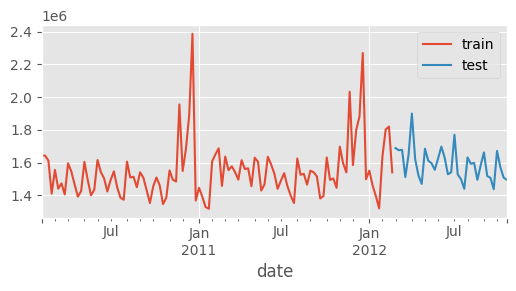

In [ ]:
steps = 35
data_train = store1_data[:-steps]
data_test  = store1_data[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Weekly_Sales'].plot(ax=ax, label='train')
data_test['Weekly_Sales'].plot(ax=ax, label='test')
ax.legend();

## Predicción recursiva

In [ ]:
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )
forecaster.fit(y=data_train['Weekly_Sales'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4 5 6] 
Window features: None 
Window size: 6 
Series name: Weekly_Sales 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2010-02-05 00:00:00'), Timestamp('2012-02-24 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-FRI 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-11 02:17:57 
Last fit date: 2025-05-11 02:17:57 
Skforecast version: 0.16.0 
Python version: 3.11.12 
Forecaster id: None

In [ ]:
steps = 35
predictions = forecaster.predict(steps=steps)
predictions.head(5)


,pred
2012-03-02,1.778123e+06
2012-03-09,1.760073e+06
2012-03-16,1.778514e+06
2012-03-23,1.721259e+06
2012-03-30,1.699929e+06


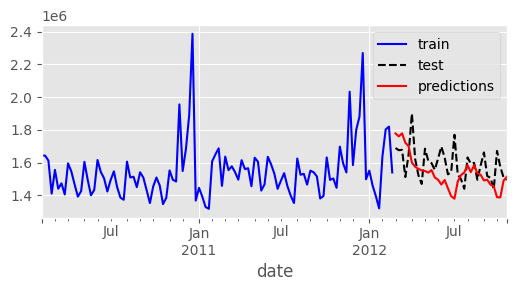

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Weekly_Sales'].plot(ax=ax, label='train',color="blue")
data_test['Weekly_Sales'].plot(ax=ax, label='test',color="black",ls='--')
predictions.plot(ax=ax, label='predictions',color='red')
ax.legend();


In [ ]:
error_mse = mean_squared_error(
                y_true = data_test['Weekly_Sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")


Test error (MSE): 18369155363.097034


In [ ]:
# Hyperparameters: grid search
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12 # This value will be replaced in the grid search
             )

# Training and validation folds
cv = TimeSeriesFold(
      steps              = 35,
      initial_train_size = int(len(data_train) * 0.5),
      refit              = False,
      fixed_train_size   = False,

    )

# Candidate values for lags
lags_grid = [10, 20]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster,
                    y           = data_train['Weekly_Sales'],
                    cv          = cv,
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    metric      = 'mean_squared_error',
                    return_best = True,
                    n_jobs      = 'auto',
                    verbose     = False
                )

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 8, 'n_estimators': 250}
  Backtesting metric: 37235879147.28929


In [ ]:
results_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 250}",3.723588e+10,8,250
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 250}",3.745180e+10,3,250
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 8, 'n_estimators': 100}",3.837821e+10,8,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",3.870090e+10,3,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",4.581741e+10,3,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 250}",4.587627e+10,3,250
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 250}",4.641689e+10,8,250
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 8, 'n_estimators': 100}",5.055001e+10,8,100


In [ ]:
regressor = RandomForestRegressor(n_estimators=250, max_depth=8, random_state=123)
forecaster = ForecasterRecursive(
                 regressor = regressor,
                 lags      = 20
             )
forecaster.fit(y=data_train['Weekly_Sales'])

In [ ]:
predictions = forecaster.predict(steps=steps)


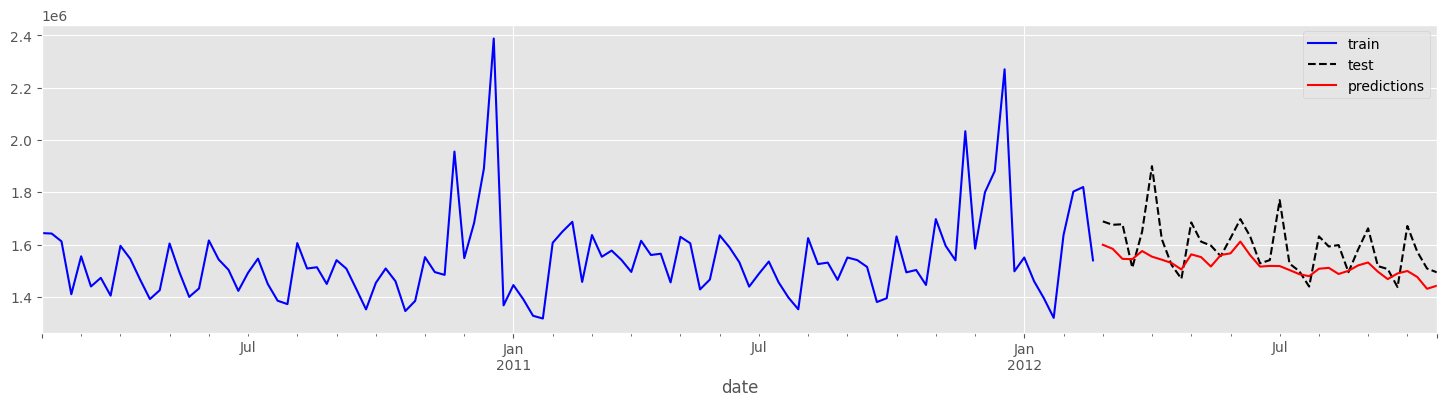

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
data_train['Weekly_Sales'].plot(ax=ax, label='train',color="blue")
data_test['Weekly_Sales'].plot(ax=ax, label='test',color="black",ls='--')
predictions.plot(ax=ax, label='predictions',color='red')
ax.legend();


In [ ]:
error_mse = mean_squared_error(
                y_true = data_test['Weekly_Sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 10939055861.112448


## Backtesting

In [ ]:
cv = TimeSeriesFold(
         steps              = 7 * 5,
         initial_train_size = len(store1_data) - 52 * 2,  # Last 9 years are separated for the backtest
         window_size        = 20,
         fixed_train_size   = False,
         refit              = True,
     )

cv.split(X=store1_data, as_pandas=True)

Information of folds
--------------------
Number of observations used for initial training: 39
Number of observations used for backtesting: 104
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 35
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 34 observations.

Fold: 0
    Training:   2010-02-05 00:00:00 -- 2010-10-29 00:00:00  (n=39)
    Validation: 2010-11-05 00:00:00 -- 2011-07-01 00:00:00  (n=35)
Fold: 1
    Training:   2010-02-05 00:00:00 -- 2011-07-01 00:00:00  (n=74)
    Validation: 2011-07-08 00:00:00 -- 2012-03-02 00:00:00  (n=35)
Fold: 2
    Training:   2010-02-05 00:00:00 -- 2012-03-02 00:00:00  (n=109)
    Validation: 2012-03-09 00:00:00 -- 2012-10-26 00:00:00  (n=34)



,fold,train_start,train_end,last_window_start,last_window_end,test_start,test_end,test_start_with_gap,test_end_with_gap,fit_forecaster
0,0,0,39,19,39,39,74,39,74,True
1,1,0,74,54,74,74,109,74,109,True
2,2,0,109,89,109,109,143,109,143,True


In [ ]:
metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = store1_data['Weekly_Sales'],
                                    cv         = cv,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                )
metric

Information of folds
--------------------
Number of observations used for initial training: 39
Number of observations used for backtesting: 104
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 35
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 34 observations.

Fold: 0
    Training:   2010-02-05 00:00:00 -- 2010-10-29 00:00:00  (n=39)
    Validation: 2010-11-05 00:00:00 -- 2011-07-01 00:00:00  (n=35)
Fold: 1
    Training:   2010-02-05 00:00:00 -- 2011-07-01 00:00:00  (n=74)
    Validation: 2011-07-08 00:00:00 -- 2012-03-02 00:00:00  (n=35)
Fold: 2
    Training:   2010-02-05 00:00:00 -- 2012-03-02 00:00:00  (n=109)
    Validation: 2012-03-09 00:00:00 -- 2012-10-26 00:00:00  (n=34)



  0%|          | 0/3 [00:00<?, ?it/s]

,mean_squared_error
0,3.724034e+10


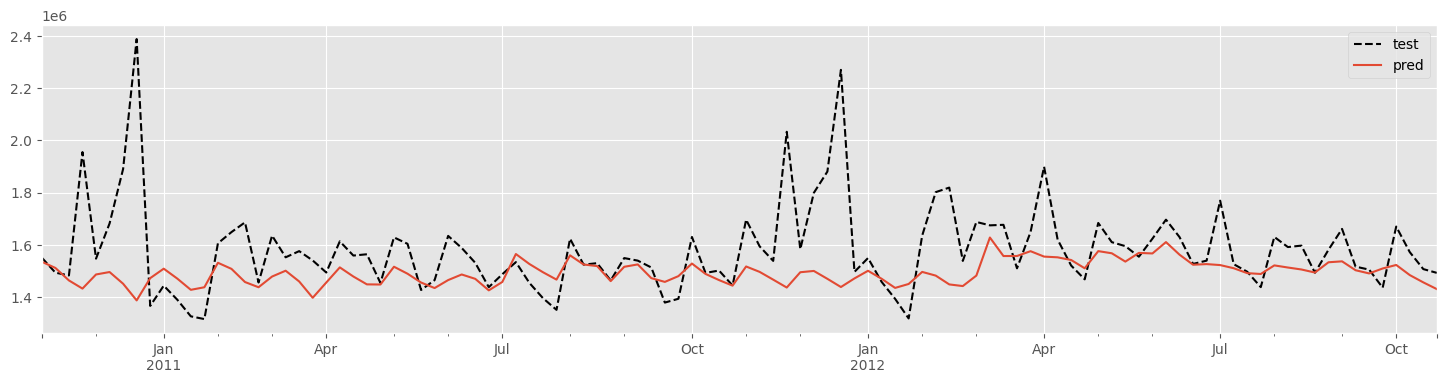

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
store1_data.loc[predictions_backtest.index, 'Weekly_Sales'].plot(ax=ax, label='test',color='black',ls="--")
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();


## Calendar features y variables exógenas

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

data = df[df['Store'] == 1]

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=data.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


In [ ]:
X

,const,trend,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)","s(10,52)","s(11,52)","s(12,52)","s(13,52)","s(14,52)","s(15,52)","s(16,52)","s(17,52)","s(18,52)","s(19,52)","s(20,52)","s(21,52)","s(22,52)","s(23,52)","s(24,52)","s(25,52)","s(26,52)","s(27,52)","s(28,52)","s(29,52)","s(30,52)","s(31,52)","s(32,52)","s(33,52)","s(34,52)","s(35,52)","s(36,52)","s(37,52)","s(38,52)","s(39,52)","s(40,52)","s(41,52)","s(42,52)","s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969
2010-02-12,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884,-0.433884,-0.900969
2010-02-19,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.781831,-0.623490,0.974928,-0.222521,-0.433884,0.900969,-0.433884,-0.900969
2010-02-26,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.623490,0.781831,-0.974928,0.222521,-0.900969,-0.433884,-0.433884,-0.900969
2010-03-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.587785,0.809017,-0.951057,0.309017,-0.951057,-0.309017,-0.587785,-0.809017
2012-10-05,1.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
2012-10-12,1.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347


In [ ]:
X['Weekly_Sales'] = data['Weekly_Sales']
X

,const,trend,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)","s(10,52)","s(11,52)","s(12,52)","s(13,52)","s(14,52)","s(15,52)","s(16,52)","s(17,52)","s(18,52)","s(19,52)","s(20,52)","s(21,52)","s(22,52)","s(23,52)","s(24,52)","s(25,52)","s(26,52)","s(27,52)","s(28,52)","s(29,52)","s(30,52)","s(31,52)","s(32,52)","s(33,52)","s(34,52)","s(35,52)","s(36,52)","s(37,52)","s(38,52)","s(39,52)","s(40,52)","s(41,52)","s(42,52)","s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)",Weekly_Sales
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,1643690.90
2010-02-12,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884,-0.433884,-0.900969,1641957.44
2010-02-19,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.781831,-0.623490,0.974928,-0.222521,-0.433884,0.900969,-0.433884,-0.900969,1611968.17
2010-02-26,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.623490,0.781831,-0.974928,0.222521,-0.900969,-0.433884,-0.433884,-0.900969,1409727.59
2010-03-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.587785,0.809017,-0.951057,0.309017,-0.951057,-0.309017,-0.587785,-0.809017,1437059.26
2012-10-05,1.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,1670785.97
2012-10-12,1.0,141.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,1573072.81


In [ ]:
X['Fuel_Price'] = store1_data['Fuel_Price']



In [ ]:
X = X.asfreq('W-Fri',fill_value=np.nan)


In [ ]:
steps = 35
data_train = X[:-steps]
data_test  = X[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Train dates : 2010-02-05 00:00:00 --- 2012-02-24 00:00:00  (n=108)
Test dates  : 2012-03-02 00:00:00 --- 2012-10-26 00:00:00  (n=35)


In [ ]:
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(n_estimators=250, max_depth=8, random_state=123),
                 lags      = 20,
                 transformer_y = StandardScaler()
             )
forecaster.fit(y=data_train['Weekly_Sales'], exog=data_train.drop('Weekly_Sales', axis=1))

In [ ]:
predictions = forecaster.predict(steps=steps, exog=data_test.drop('Weekly_Sales', axis=1))


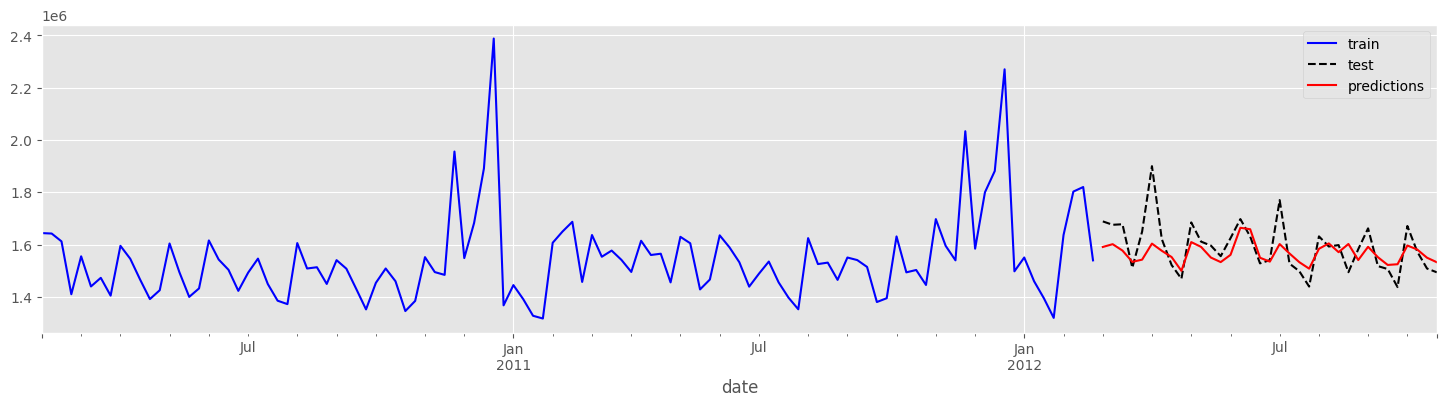

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
data_train['Weekly_Sales'].plot(ax=ax, label='train',color="blue")
data_test['Weekly_Sales'].plot(ax=ax, label='test',color='black',ls="--")
predictions.plot(ax=ax, label='predictions',color="red")
ax.legend();

In [ ]:
error_mse = mean_squared_error(
                y_true = data_test['Weekly_Sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")


Test error (MSE): 6258294851.729495


## Window features

'mean': the mean of the previous n values.

'std': the standard deviation of the previous n values.

'min': the minimum of the previous n values.

'max': the maximum of the previous n values.

'sum': the sum of the previous n values.

'median': the median of the previous n values.

'ratio_min_max': the ratio between the minimum and maximum of the previous n values.

'coef_variation': the coefficient of variation of the previous n values.

In [ ]:
window_features = RollingFeatures(
    stats = ['mean', 'std', 'min', 'max'],
    window_sizes = 20
)

In [ ]:
forecaster = ForecasterRecursive(
                regressor       = RandomForestRegressor(n_estimators=250, max_depth=8,random_state=123),
                lags            = 20,
                window_features = window_features,
                transformer_y = StandardScaler()
             )
forecaster.fit(y=data_train['Weekly_Sales'], exog=data_train.drop('Weekly_Sales', axis=1))
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Window features: ['roll_mean_20', 'roll_std_20', 'roll_min_20', 'roll_max_20'] 
Window size: 20 
Series name: Weekly_Sales 
Exogenous included: True 
Exogenous names: 
    const, trend, s(2,52), s(3,52), s(4,52), s(5,52), s(6,52), s(7,52), s(8,52),
    s(9,52), s(10,52), s(11,52), s(12,52), s(13,52), s(14,52), s(15,52),
    s(16,52), s(17,52), s(18,52), s(19,52), s(20,52), s(21,52), s(22,52),
    s(23,52), s(24,52), ..., s(37,52), s(38,52), s(39,52), s(40,52), s(41,52),
    s(42,52), s(43,52), s(44,52), s(45,52), s(46,52), s(47,52), s(48,52),
    s(49,52), s(50,52), s(51,52), s(52,52), sin(1,freq=ME), cos(1,freq=ME),
    sin(2,freq=ME), cos(2,freq=ME), sin(3,freq=ME), cos(3,freq=ME),
    sin(4,freq=ME), cos(4,freq=ME), Fuel_Price 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2010-02-05 00:00:00'), Timestamp('2012-02-24 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-FRI 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    8, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 250,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-05-11 02:45:22 
Last fit date: 2025-05-11 02:45:23 
Skforecast version: 0.16.0 
Python version: 3.11.12 
Forecaster id: None

In [ ]:
X_train, y_train = forecaster.create_train_X_y(y=data_train['Weekly_Sales'])
display(X_train.head(5))
display(y_train.head(5))

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,roll_mean_20,roll_std_20,roll_min_20,roll_max_20
date,,,,,,,,,,,,,,,,,,,,,,,,
2010-06-25,-0.239795,-0.006913,0.425705,-0.662040,-0.854193,-0.293351,0.357106,-0.703362,-0.904034,-0.460515,0.010029,0.303821,-0.825924,-0.422227,-0.617739,0.065694,-0.794513,0.404617,0.582430,0.592709,-0.202125,0.520704,-0.904034,0.592709
2010-07-02,-0.717528,-0.239795,-0.006913,0.425705,-0.662040,-0.854193,-0.293351,0.357106,-0.703362,-0.904034,-0.460515,0.010029,0.303821,-0.825924,-0.422227,-0.617739,0.065694,-0.794513,0.404617,0.582430,-0.267637,0.497339,-0.904034,0.582430
2010-07-09,-0.304222,-0.717528,-0.239795,-0.006913,0.425705,-0.662040,-0.854193,-0.293351,0.357106,-0.703362,-0.904034,-0.460515,0.010029,0.303821,-0.825924,-0.422227,-0.617739,0.065694,-0.794513,0.404617,-0.311969,0.455319,-0.904034,0.425705
2010-07-16,0.013917,-0.304222,-0.717528,-0.239795,-0.006913,0.425705,-0.662040,-0.854193,-0.293351,0.357106,-0.703362,-0.904034,-0.460515,0.010029,0.303821,-0.825924,-0.422227,-0.617739,0.065694,-0.794513,-0.331504,0.430670,-0.904034,0.425705
2010-07-23,-0.562020,0.013917,-0.304222,-0.717528,-0.239795,-0.006913,0.425705,-0.662040,-0.854193,-0.293351,0.357106,-0.703362,-0.904034,-0.460515,0.010029,0.303821,-0.825924,-0.422227,-0.617739,0.065694,-0.319880,0.420533,-0.904034,0.425705


,y
date,
2010-06-25,-0.717528
2010-07-02,-0.304222
2010-07-09,0.013917
2010-07-16,-0.562020
2010-07-23,-0.940742


In [ ]:
steps = 35
predictions = forecaster.predict(steps=steps,exog=data_test.drop('Weekly_Sales', axis=1))

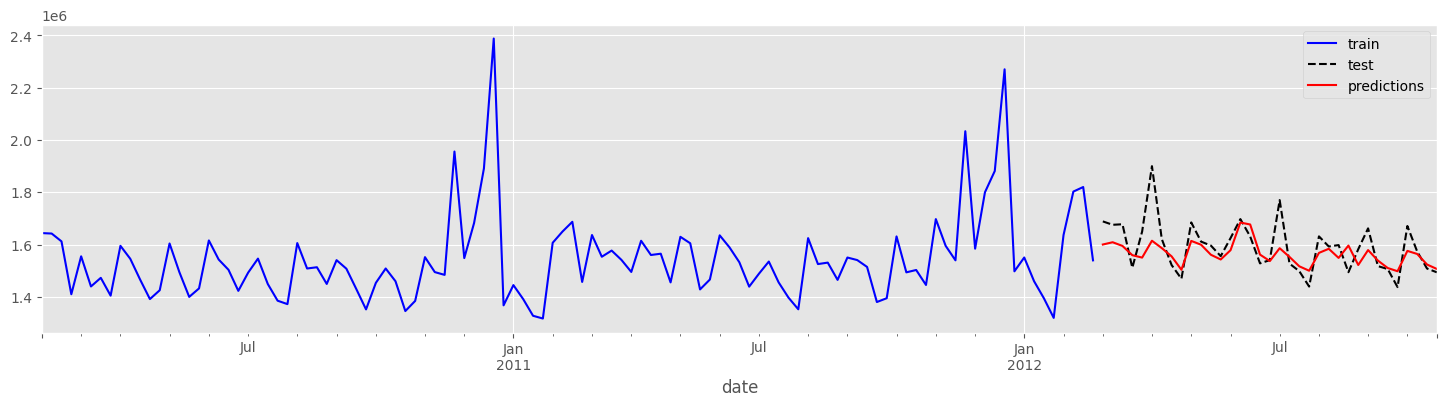

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
data_train['Weekly_Sales'].plot(ax=ax, label='train',color="blue")
data_test['Weekly_Sales'].plot(ax=ax, label='test',color="black",ls="--")
predictions.plot(ax=ax, label='predictions',color="red")
ax.legend();

In [ ]:
error_mse = mean_squared_error(
                y_true = data_test['Weekly_Sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 5941571904.580352


## Model explainability

In [ ]:
importance = forecaster.get_feature_importances()
importance.head(10)


,feature,importance
61,"s(47,52)",0.287369
67,"sin(1,freq=ME)",0.128715
57,"s(43,52)",0.118883
60,"s(46,52)",0.047617
15,trend,0.045055
8,lag_9,0.042918
0,lag_1,0.034552
3,lag_4,0.032702
73,"sin(4,freq=ME)",0.025719
7,lag_8,0.025706


## Direct forecasting

In [ ]:
forecaster = ForecasterDirect(
                 regressor     = RandomForestRegressor(n_estimators=250, max_depth=8,random_state=123),
                 steps         = 35,
                 lags          = 8,  # This value will be replaced in the grid search
                 transformer_y = StandardScaler()
             )


In [ ]:
data_train

,const,trend,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)","s(10,52)","s(11,52)","s(12,52)","s(13,52)","s(14,52)","s(15,52)","s(16,52)","s(17,52)","s(18,52)","s(19,52)","s(20,52)","s(21,52)","s(22,52)","s(23,52)","s(24,52)","s(25,52)","s(26,52)","s(27,52)","s(28,52)","s(29,52)","s(30,52)","s(31,52)","s(32,52)","s(33,52)","s(34,52)","s(35,52)","s(36,52)","s(37,52)","s(38,52)","s(39,52)","s(40,52)","s(41,52)","s(42,52)","s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)",Weekly_Sales,Fuel_Price
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,1643690.90,2.572
2010-02-12,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884,-0.433884,-0.900969,1641957.44,2.548
2010-02-19,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.781831,-0.623490,0.974928,-0.222521,-0.433884,0.900969,-0.433884,-0.900969,1611968.17,2.514
2010-02-26,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.623490,0.781831,-0.974928,0.222521,-0.900969,-0.433884,-0.433884,-0.900969,1409727.59,2.561
2010-03-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,1554806.68,2.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-27,1.0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.848644,0.528964,-0.897805,-0.440394,-0.101168,-0.994869,0.790776,-0.612106,1319325.59,3.290
2012-02-03,1.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.419889,0.907575,0.762162,0.647386,0.963550,0.267528,0.986827,-0.161782,1636339.65,3.360
2012-02-10,1.0,106.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.928977,-0.370138,-0.687699,-0.725995,-0.419889,0.907575,0.998533,0.054139,1802477.43,3.409


In [ ]:
from skforecast.exceptions import LongTrainingWarning
import warnings
warnings.filterwarnings("ignore", category=LongTrainingWarning)
cv = TimeSeriesFold(
         steps              = 35,
         initial_train_size = int(len(data_train) * 0.5),
         fixed_train_size   = False,
         refit              = False,
)

param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}
lags_grid = [5, 12]

results_grid = grid_search_forecaster(
                    forecaster   = forecaster,
                    y            = data_train['Weekly_Sales'],
                    exog=data_train.drop('Weekly_Sales', axis=1),
                    cv           = cv,
                    param_grid   = param_grid,
                    lags_grid    = lags_grid,
                    metric       = 'mean_squared_error',
                    return_best  = True
                )

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 45840960515.20694


In [ ]:
results_grid.head()


,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 250}",4.584096e+10,3,250
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 8, 'n_estimators': 250}",4.594776e+10,8,250
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 100}",4.644866e+10,3,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 8, 'n_estimators': 100}",4.669930e+10,8,100
4,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 100}",5.049297e+10,3,100


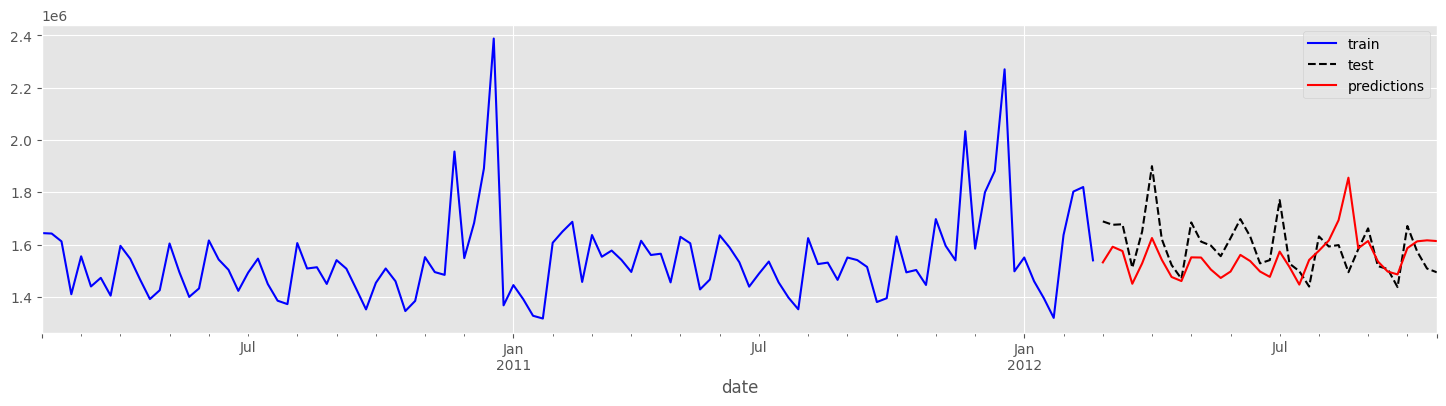

In [ ]:
predictions = forecaster.predict(steps=35,exog=data_test.drop('Weekly_Sales', axis=1))

fig, ax = plt.subplots(figsize=(18, 4))
data_train['Weekly_Sales'].plot(ax=ax, label='train',color="blue")
data_test['Weekly_Sales'].plot(ax=ax, label='test',ls="--",color="black")
predictions.plot(ax=ax, label='predictions',color="red")
ax.legend();


In [ ]:
error_mse = mean_squared_error(
                y_true = data_test['Weekly_Sales'],
                y_pred = predictions
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 13305744022.07227


## Valores futuros

En este ejemplo, para predecir valores futuros usando variables exógenas, es necesario conocer los valores futuros de estas variables, lo que no siempre es posible. En este caso conviene usar modelos "multi-series", donde se modelan más variables al mismo tiempo.

# Modelos multi-serie: Global forecaster

In [ ]:
import sklearn
import skforecast
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    backtesting_forecaster,
    bayesian_search_forecaster,
    backtesting_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.preprocessing import RollingFeatures, series_long_to_dict, exog_long_to_dict
from skforecast.exceptions import OneStepAheadValidationWarning


In [ ]:
X.head()

,const,trend,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)","s(10,52)","s(11,52)","s(12,52)","s(13,52)","s(14,52)","s(15,52)","s(16,52)","s(17,52)","s(18,52)","s(19,52)","s(20,52)","s(21,52)","s(22,52)","s(23,52)","s(24,52)","s(25,52)","s(26,52)","s(27,52)","s(28,52)","s(29,52)","s(30,52)","s(31,52)","s(32,52)","s(33,52)","s(34,52)","s(35,52)","s(36,52)","s(37,52)","s(38,52)","s(39,52)","s(40,52)","s(41,52)","s(42,52)","s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)",Weekly_Sales,Fuel_Price
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,1643690.90,2.572
2010-02-12,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884,-0.433884,-0.900969,1641957.44,2.548
2010-02-19,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.781831,-0.623490,0.974928,-0.222521,-0.433884,0.900969,-0.433884,-0.900969,1611968.17,2.514
2010-02-26,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.623490,0.781831,-0.974928,0.222521,-0.900969,-0.433884,-0.433884,-0.900969,1409727.59,2.561
2010-03-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,1554806.68,2.625


In [ ]:
selected_columns = [col for col in X.columns if col.startswith('sin') or col.startswith('cos') or col == 'Weekly_Sales' or col == 'Fuel_Price']
data = X[selected_columns]

In [ ]:
data

,"sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)",Weekly_Sales,Fuel_Price
date,,,,,,,,,,
2010-02-05,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,1643690.90,2.572
2010-02-12,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884,-0.433884,-0.900969,1641957.44,2.548
2010-02-19,-0.781831,-0.623490,0.974928,-0.222521,-0.433884,0.900969,-0.433884,-0.900969,1611968.17,2.514
2010-02-26,-0.623490,0.781831,-0.974928,0.222521,-0.900969,-0.433884,-0.433884,-0.900969,1409727.59,2.561
2010-03-05,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,1554806.68,2.625
...,...,...,...,...,...,...,...,...,...,...
2012-09-28,-0.587785,0.809017,-0.951057,0.309017,-0.951057,-0.309017,-0.587785,-0.809017,1437059.26,3.666
2012-10-05,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,1670785.97,3.617
2012-10-12,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,1573072.81,3.601


In [ ]:
end_train = "2010-12-31 00:00:00"
end_val = "2011-12-02 00:00:00"

data_train = data.loc[:end_train, :].copy()
data_val   = data.loc[end_train:end_val, :].copy()
data_test  = data.loc[end_val:, :].copy()
print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates      : 2010-02-05 00:00:00 --- 2010-12-31 00:00:00  (n=48)
Validation dates : 2010-12-31 00:00:00 --- 2011-12-02 00:00:00  (n=49)
Test dates       : 2011-12-02 00:00:00 --- 2012-10-26 00:00:00  (n=48)


In [ ]:
data.columns

Index(['sin(1,freq=ME)', 'cos(1,freq=ME)', 'sin(2,freq=ME)', 'cos(2,freq=ME)',
       'sin(3,freq=ME)', 'cos(3,freq=ME)', 'sin(4,freq=ME)', 'cos(4,freq=ME)',
       'Weekly_Sales', 'Fuel_Price', 'day', 'month', 'year', 'dayofweek'],
      dtype='object')

In [ ]:
data['day']=data.index.day
data['month']=data.index.month
data['year']=data.index.year
data['dayofweek']=data.index.dayofweek

<ipython-input-92-22cc5a6fc566>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day']=data.index.day
<ipython-input-92-22cc5a6fc566>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month']=data.index.month
<ipython-input-92-22cc5a6fc566>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [ ]:
data

,"sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)",Weekly_Sales,Fuel_Price,day,month,year,dayofweek
date,,,,,,,,,,,,,,
2010-02-05,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,1643690.90,2.572,5,2,2010,4
2010-02-12,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884,-0.433884,-0.900969,1641957.44,2.548,12,2,2010,4
2010-02-19,-0.781831,-0.623490,0.974928,-0.222521,-0.433884,0.900969,-0.433884,-0.900969,1611968.17,2.514,19,2,2010,4
2010-02-26,-0.623490,0.781831,-0.974928,0.222521,-0.900969,-0.433884,-0.433884,-0.900969,1409727.59,2.561,26,2,2010,4
2010-03-05,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,1554806.68,2.625,5,3,2010,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,-0.587785,0.809017,-0.951057,0.309017,-0.951057,-0.309017,-0.587785,-0.809017,1437059.26,3.666,28,9,2012,4
2012-10-05,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,1670785.97,3.617,5,10,2012,4
2012-10-12,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,1573072.81,3.601,12,10,2012,4


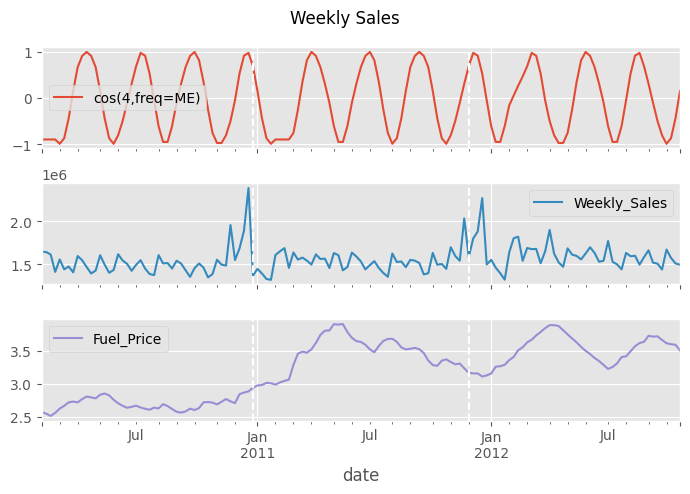

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
data.iloc[:, 7:10].plot(
    legend   = True,
    subplots = True,
    title    = 'Weekly Sales',
    ax       = axs,
)
for ax in axs:
    ax.axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1.5)
    ax.axvline(pd.to_datetime(end_val) , color='white', linestyle='--', linewidth=1.5)
fig.tight_layout()
plt.show()


In [ ]:
items = list(data.columns)

# Define forecaster
window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=7)
forecaster_ms = ForecasterRecursiveMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=853),
                    lags               = 21,
                    encoding           = 'ordinal',
                    transformer_series = StandardScaler(),
                    window_features    = window_features,
                )
# Backtesting forecaster for all items
cv = TimeSeriesFold(
        steps              = 14,
        initial_train_size = len(data_train) + len(data_val),
        refit              = False,
     )
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster = forecaster_ms,
                                       series     = data,
                                       levels     = items,
                                       cv         = cv,
                                       metric     = 'mean_absolute_error',
                                   )
# Results
display(multi_series_mae.head(3))
print('')
display(predictions_ms.head(3))

  0%|          | 0/4 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,"sin(1,freq=ME)",0.066215
1,"cos(1,freq=ME)",0.081920
2,"sin(2,freq=ME)",0.121340


,level,pred
2011-12-16,"sin(1,freq=ME)",0.047601
2011-12-16,"cos(1,freq=ME)",-0.983890
2011-12-16,"sin(2,freq=ME)",-0.165707


In [ ]:
predictions_sales=predictions_ms[predictions_ms['level']=="Weekly_Sales"]

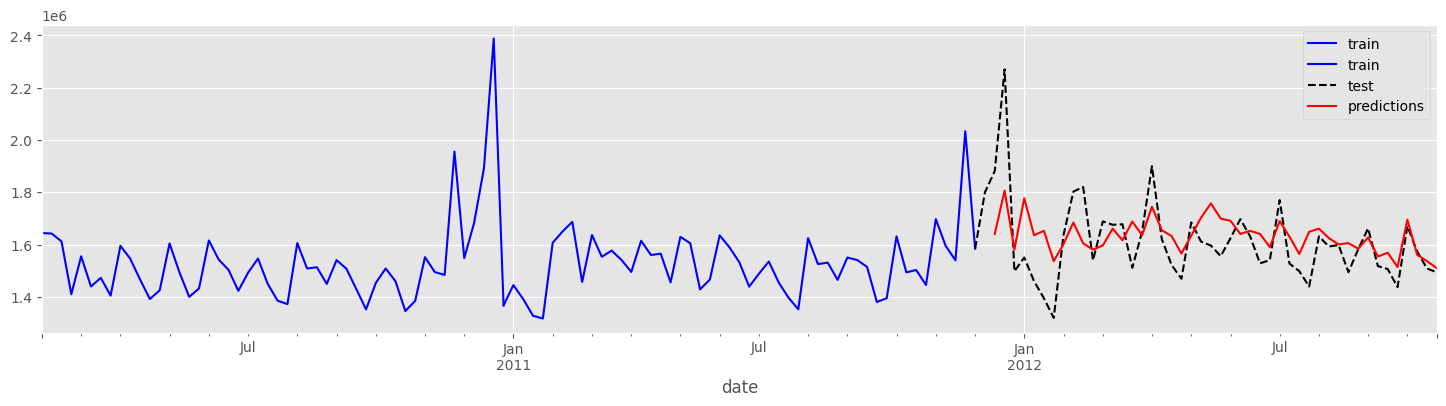

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
data_train['Weekly_Sales'].plot(ax=ax, label='train',color="blue")
data_val['Weekly_Sales'].plot(ax=ax, label='train',color="blue")
data_test['Weekly_Sales'].plot(ax=ax, label='test',color="black",ls="--")
predictions_sales["pred"].plot(ax=ax, label='predictions',color="red")
ax.legend();

In [ ]:
def search_space(trial):
    search_space  = {
        'lags'          : trial.suggest_categorical('lags', [7, 14]),
        'max_iter'      : trial.suggest_int('max_iter', 100, 500),
        'max_depth'     : trial.suggest_int('max_depth', 5, 10),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.1)
    }

    return search_space
cv_search = OneStepAheadFold(initial_train_size = len(data_train))

window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=7)
forecaster_ms = ForecasterRecursiveMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=123),
                    lags               = 14,
                    window_features    = window_features,
                    transformer_series = StandardScaler(),
                    encoding           = 'ordinal'
                )

results_bayesian_ms = bayesian_search_forecaster_multiseries(
                        forecaster    = forecaster_ms,
                        series        = data.loc[:end_val, :],
                        levels        = None, # Si es None se seleccionan todos los niveles
                        cv            = cv_search,
                        search_space  = search_space,
                        n_trials      = 20,
                        metric        = 'mean_absolute_error',
                        show_progress = False
                    )
cv_backtesting = TimeSeriesFold(
                        steps              = 7,
                        initial_train_size = len(data_train) + len(data_val),
                        refit              = False,
                      )
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster            = forecaster_ms,
                                       series                = data,
                                       levels                = None, # Si es None se seleccionan todos los niveles
                                       cv                    = cv_backtesting,
                                       metric                = 'mean_absolute_error',
                                       add_aggregated_metric = False,
                                   )

╭─────────────────────────── OneStepAheadValidationWarning ────────────────────────────╮
│ One-step-ahead predictions are used for faster model comparison, but they may not    │
│ fully represent multi-step prediction performance. It is recommended to backtest the │
│ final model for a more accurate multi-step performance estimate.                     │
│                                                                                      │
│ Category : OneStepAheadValidationWarning                                             │
│ Location :                                                                           │
│ /usr/local/lib/python3.11/dist-packages/skforecast/model_selection/_utils.py:693     │
│ Suppress : warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)   │
╰──────────────────────────────────────────────────────────────────────────────────────╯

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'max_iter': 374, 'max_depth': 7, 'learning_rate': 0.04529057663747355}
  Backtesting metric: 5286.003659080556
  Levels: ['sin(1,freq=ME)', 'cos(1,freq=ME)', 'sin(2,freq=ME)', 'cos(2,freq=ME)', 'sin(3,freq=ME)', 'cos(3,freq=ME)', 'sin(4,freq=ME)', 'cos(4,freq=ME)', 'Weekly_Sales', 'Fuel_Price', 'day', 'month', 'year', 'dayofweek']



  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
forecaster_ms = ForecasterRecursiveMultiSeries(
                    regressor          = HistGradientBoostingRegressor(max_iter=374, max_depth=7, learning_rate=0.04529057663747355),
                    lags               = 14,
                    window_features    = window_features,
                    transformer_series = StandardScaler(),
                    encoding           = 'ordinal'
                )

In [ ]:
predictions_sales=predictions_ms[predictions_ms['level']=="Weekly_Sales"]

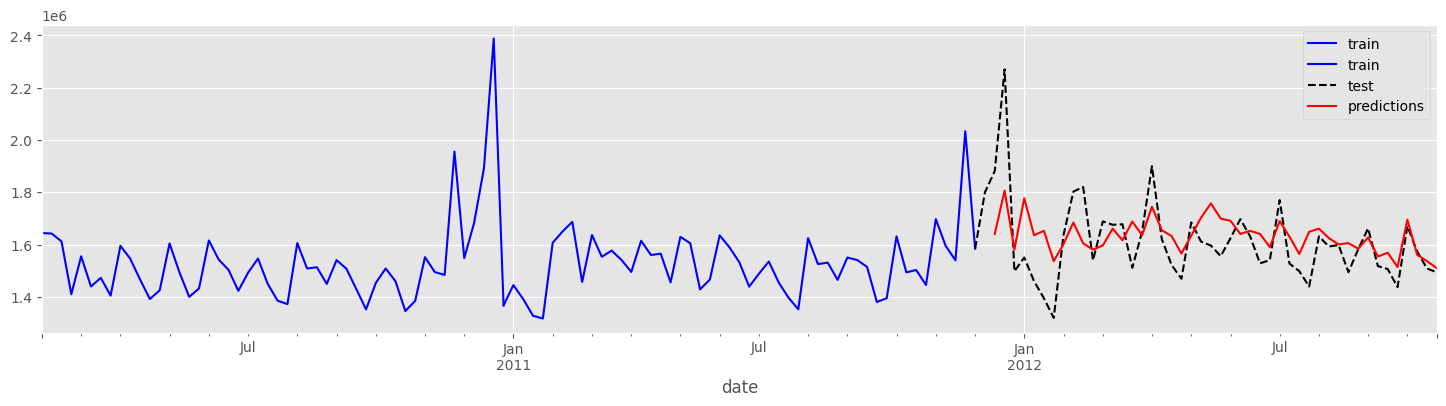

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
data_train['Weekly_Sales'].plot(ax=ax, label='train',color="blue")
data_val['Weekly_Sales'].plot(ax=ax, label='train',color="blue")
data_test['Weekly_Sales'].plot(ax=ax, label='test',color="black",ls="--")
predictions_sales["pred"].plot(ax=ax, label='predictions',color="red")
ax.legend();

In [ ]:
data_test_plot = data_test[2:]

data_test_plot['Weekly_Sales'] = data_test_plot['Weekly_Sales'].astype(float)

<ipython-input-100-40a80f6d9d01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_plot['Weekly_Sales'] = data_test_plot['Weekly_Sales'].astype(float)


In [ ]:
data_test_plot.shape

(46, 14)

In [ ]:
error_mse = mean_squared_error(
                y_true = data_test_plot['Weekly_Sales'],
                y_pred = predictions_sales['pred']
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 17490866553.18561


In [ ]:
forecaster_ms.fit(data)
predictions = forecaster_ms.predict(steps=10)

In [ ]:
predictions

,level,pred
2012-11-02,Fuel_Price,3.568008e+00
2012-11-02,Weekly_Sales,1.626487e+06
2012-11-02,"cos(1,freq=ME)",8.961543e-01
2012-11-02,"cos(2,freq=ME)",8.279027e-01
2012-11-02,"cos(3,freq=ME)",4.958529e-01
...,...,...
2013-01-04,"sin(1,freq=ME)",6.138950e-01
2013-01-04,"sin(2,freq=ME)",9.823439e-01
2013-01-04,"sin(3,freq=ME)",8.528317e-01
2013-01-04,"sin(4,freq=ME)",3.795929e-01


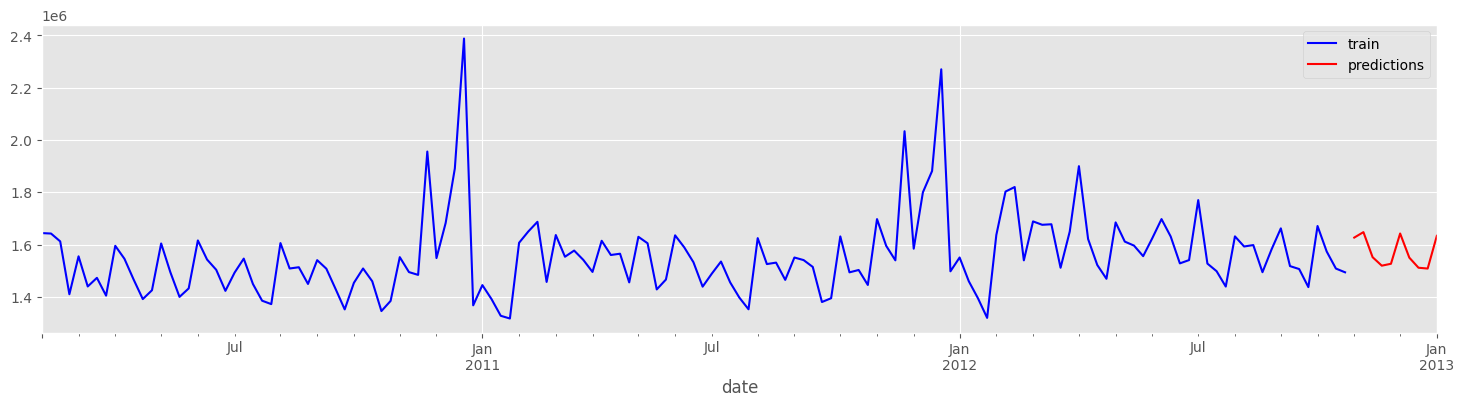

In [ ]:
predictions_sales=predictions[predictions['level']=="Weekly_Sales"]
fig, ax = plt.subplots(figsize=(18, 4))
data['Weekly_Sales'].plot(ax=ax, label='train',color="blue")
predictions_sales["pred"].plot(ax=ax, label='predictions',color="red")
ax.legend();

# Probabilistic forecasting

La predicción probabilística, a diferencia de la predicción puntual, es una familia de técnicas que permiten predecir la distribución esperada del resultado en lugar de un solo valor futuro. Este tipo de predicción proporciona información mucho más rica porque permite la creación de intervalos de predicción, el rango de valores probables donde puede caer el valor verdadero. Más formalmente, un intervalo de predicción define el intervalo dentro del cual se espera encontrar el valor verdadero de la variable de respuesta con una probabilidad determinada."

La predicción probabilística es especialmente útil en aplicaciones donde la incertidumbre es importante, como en la planificación financiera, la gestión de riesgos y la toma de decisiones estratégicas. Al proporcionar una distribución de probabilidad sobre los posibles resultados, permite a los usuarios tomar decisiones más informadas y gestionar mejor los riesgos asociados con las predicciones.

Bootstrapping

Es un método utilizado para estimar la incertidumbre en las predicciones mediante el remuestreo de errores de predicción pasados (residuos). El objetivo es generar intervalos de predicción que capturen la variabilidad en la predicción, proporcionando un rango de posibles valores futuros en lugar de solo una estimación puntual.
El error de una predicción un paso adelante se define como la diferencia entre el valor real y el valor predicho $e_t=y_t-\hat{y}_{t|t-1}$
. Al asumir que los errores futuros serán similares a los errores pasados, es posible simular diferentes predicciones tomando muestras de la colección de errores previamente vistos en el pasado (es decir, los residuos) y sumándolos a las predicciones.
Este método es útil para cuantificar la incertidumbre en las predicciones y proporcionar una visión más completa de los posibles resultados futuros. Al utilizar el bootstrapping de residuos, se pueden generar intervalos de predicción más realistas y precisos.

In [ ]:
steps = 35
data_train = X[:-steps]
data_test  = X[-steps:]
print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Train dates : 2010-02-05 00:00:00 --- 2012-02-24 00:00:00  (n=108)
Test dates  : 2012-03-02 00:00:00 --- 2012-10-26 00:00:00  (n=35)


In [ ]:
X.head()

,const,trend,"s(2,52)","s(3,52)","s(4,52)","s(5,52)","s(6,52)","s(7,52)","s(8,52)","s(9,52)","s(10,52)","s(11,52)","s(12,52)","s(13,52)","s(14,52)","s(15,52)","s(16,52)","s(17,52)","s(18,52)","s(19,52)","s(20,52)","s(21,52)","s(22,52)","s(23,52)","s(24,52)","s(25,52)","s(26,52)","s(27,52)","s(28,52)","s(29,52)","s(30,52)","s(31,52)","s(32,52)","s(33,52)","s(34,52)","s(35,52)","s(36,52)","s(37,52)","s(38,52)","s(39,52)","s(40,52)","s(41,52)","s(42,52)","s(43,52)","s(44,52)","s(45,52)","s(46,52)","s(47,52)","s(48,52)","s(49,52)","s(50,52)","s(51,52)","s(52,52)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)",Weekly_Sales,Fuel_Price
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,-0.433884,-0.900969,1643690.90,2.572
2010-02-12,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884,-0.433884,-0.900969,1641957.44,2.548
2010-02-19,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.781831,-0.623490,0.974928,-0.222521,-0.433884,0.900969,-0.433884,-0.900969,1611968.17,2.514
2010-02-26,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.623490,0.781831,-0.974928,0.222521,-0.900969,-0.433884,-0.433884,-0.900969,1409727.59,2.561
2010-03-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,1554806.68,2.625


In [ ]:
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=765),
                 lags      = 14,
                 transformer_y = StandardScaler()

             )
forecaster.fit(y=data_train['Weekly_Sales'],exog=data_train.drop("Weekly_Sales",axis=1),store_in_sample_residuals=True)

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                steps    = steps,
                interval = [5, 95],
                method   = 'bootstrapping',
                n_boot   = 300,
                exog=data_test.drop("Weekly_Sales",axis=1)
              )
predictions.head(5)

,pred,lower_bound,upper_bound
2012-03-02,1.636853e+06,1.626408e+06,1.700142e+06
2012-03-09,1.683846e+06,1.725655e+06,1.881475e+06
2012-03-16,1.640544e+06,1.633764e+06,1.707497e+06
2012-03-23,1.533293e+06,1.500311e+06,1.563371e+06
2012-03-30,1.520372e+06,1.506228e+06,1.570171e+06


Test error (MSE): 6254937434.919827


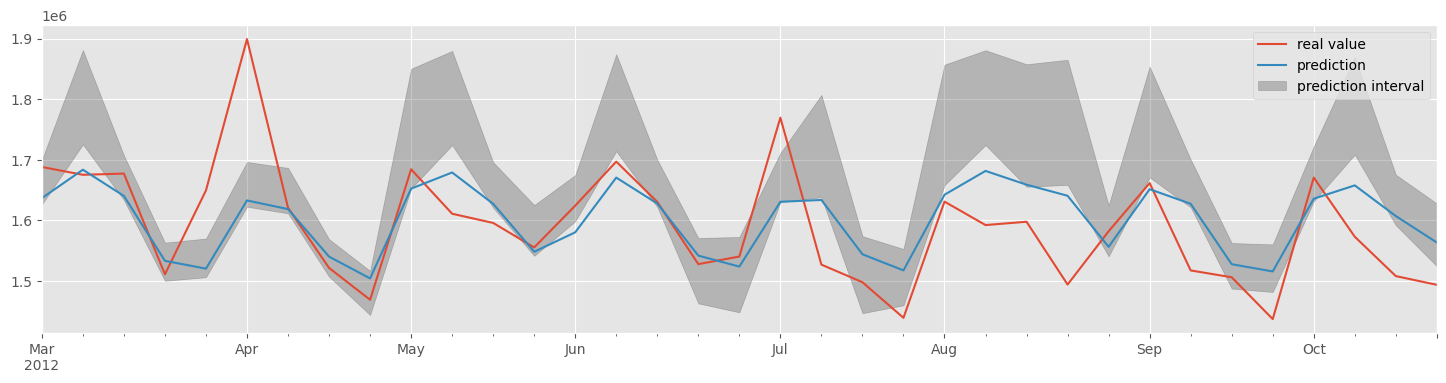

In [ ]:
error_mse = mean_squared_error(
                y_true = data_test['Weekly_Sales'],
                y_pred = predictions.iloc[:, 0],
            )
print(f"Test error (MSE): {error_mse}")

# Plot forecasts with prediction intervals
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 4))
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "Weekly_Sales",
    ax              = ax
)


In [ ]:
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=765),
                 lags      = 14,
                 transformer_y = StandardScaler()
             )
cv = TimeSeriesFold(
         steps              = 35,
         initial_train_size = len(X) - 7 * 5,
         fixed_train_size   = False,
         refit              = True,
)
metric, predictions = backtesting_forecaster(
                            forecaster      = forecaster,
                            y               = X['Weekly_Sales'],
                            cv              = cv,
                            metric          = 'mean_squared_error',
                            interval        = [5, 95],
                            interval_method = "bootstrapping",
                            n_boot          = 150,
                            verbose         = True,
                            exog = X.drop("Weekly_Sales",axis=1)
                       )
display(metric)



Information of folds
--------------------
Number of observations used for initial training: 108
Number of observations used for backtesting: 35
    Number of folds: 1
    Number skipped folds: 0 
    Number of steps per fold: 35
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2010-02-05 00:00:00 -- 2012-02-24 00:00:00  (n=108)
    Validation: 2012-03-02 00:00:00 -- 2012-10-26 00:00:00  (n=35)



  0%|          | 0/1 [00:00<?, ?it/s]

,mean_squared_error
0,6.254937e+09


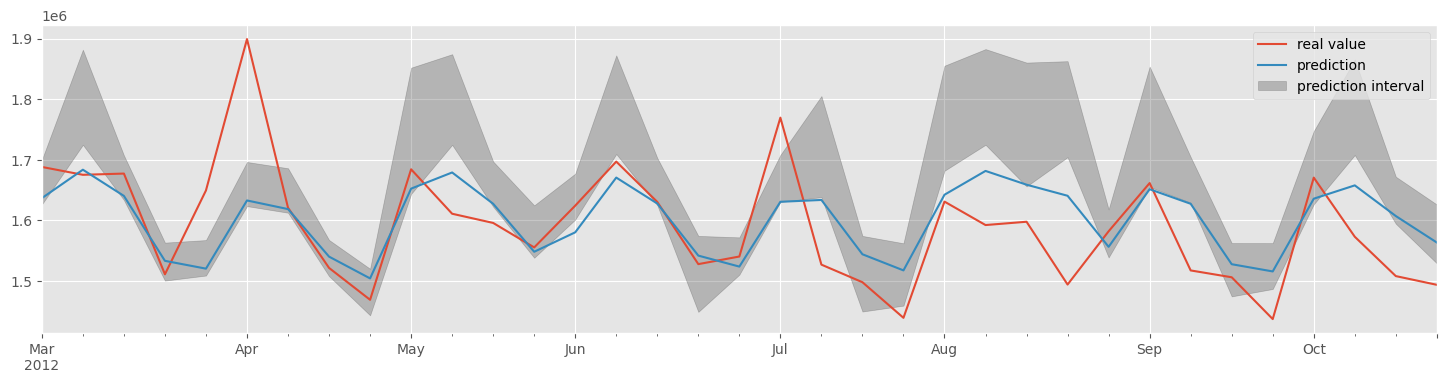

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = X.loc[predictions.index, :],
    target_variable = "Weekly_Sales",
    ax              = ax
)